<a href="https://colab.research.google.com/github/RyanAleixo/Profiss-o-Cientista-de-Dados-v2/blob/main/Projeto_de_Parceria_%7C_Semantix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from google.colab import files
import io

In [2]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]), delimiter=',')
print(df.head())

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (1).csv
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No 

In [3]:
#TRATAMENTO DE DADOS

# A coluna 'TotalCharges' veio como texto, mas contém números.
# Espaços vazios serão transformados em NaN (nulo) pelo 'coerce'
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Verificando quantos nulos a conversão acima gerou (geralmente são clientes com 0 meses de casa)
print(f"Nulos encontrados em TotalCharges: {df['TotalCharges'].isnull().sum()}")
df.dropna(subset=['TotalCharges'], inplace=True)

# Padronizar 'No internet service' para apenas 'No' facilita a leitura do modelo e dos gráficos
cols_redundantes = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cols_redundantes:
    df[col] = df[col].replace('No internet service', 'No')

# Criando uma versão numérica do Churn para permitir correlação matemática
df['Churn_Numeric'] = df['Churn'].map({'Yes': 1, 'No': 0})

#Remoção de ID
df.drop('customerID', axis=1, inplace=True)


Nulos encontrados em TotalCharges: 11


/tmp/ipython-input-3669405507.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='TechSupport', y='Churn_Numeric', palette='magma')


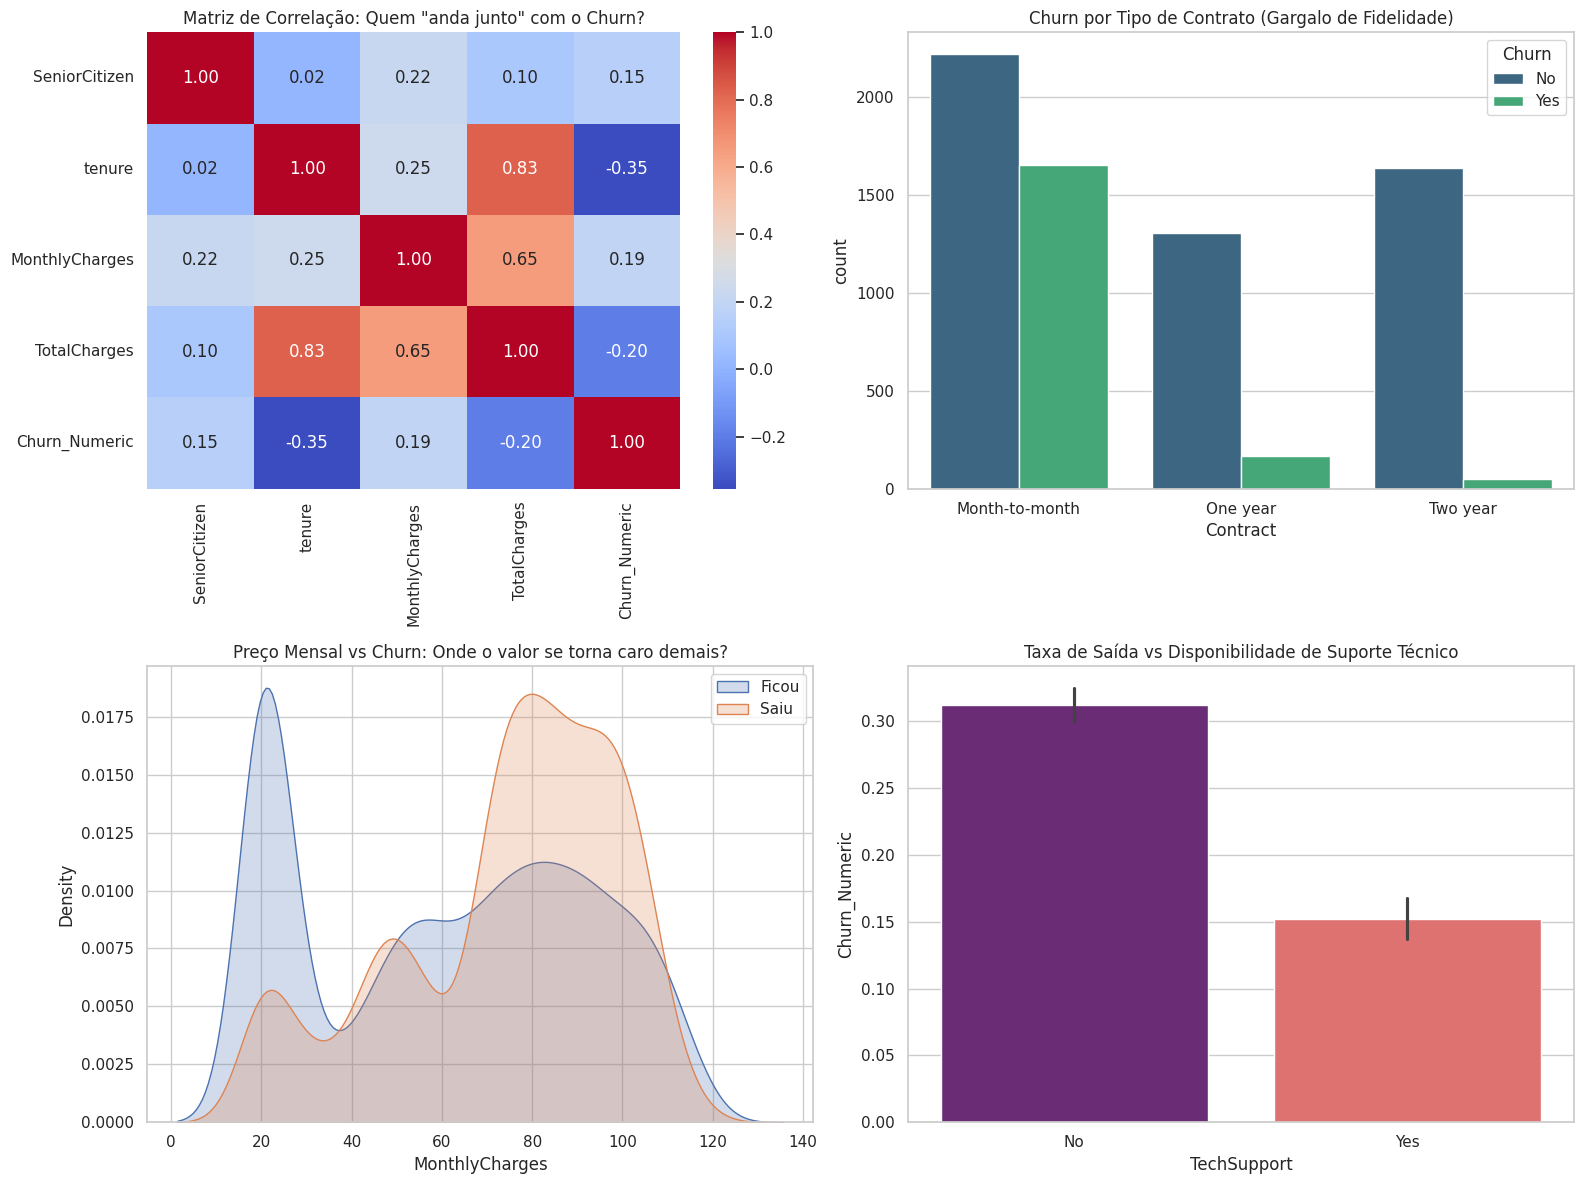

In [4]:
#ANÁLISE EXPLORATÓRIA E VARIÁVEIS CORELACIONADAS

# Configuração de Estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 12))

# INSIGHT 1: Correlação entre Variáveis Numéricas
# Mostra como Tenure (tempo de casa), Mensalidade e Churn se conectam
plt.subplot(2, 2, 1)
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação: Quem "anda junto" com o Churn?')

# INSIGHT 2: O impacto do Contrato na Retenção
plt.subplot(2, 2, 2)
sns.countplot(data=df, x='Contract', hue='Churn', palette='viridis')
plt.title('Churn por Tipo de Contrato (Gargalo de Fidelidade)')

# INSIGHT 3: Distribuição de Custos Mensais
plt.subplot(2, 2, 3)
sns.kdeplot(df.loc[(df['Churn'] == 'No'), 'MonthlyCharges'], label='Ficou', fill=True)
sns.kdeplot(df.loc[(df['Churn'] == 'Yes'), 'MonthlyCharges'], label='Saiu', fill=True)
plt.title('Preço Mensal vs Churn: Onde o valor se torna caro demais?')
plt.legend()

# INSIGHT 4: O papel do Suporte Técnico
plt.subplot(2, 2, 4)
sns.barplot(data=df, x='TechSupport', y='Churn_Numeric', palette='magma')
plt.title('Taxa de Saída vs Disponibilidade de Suporte Técnico')

plt.tight_layout()
plt.show()

In [5]:
# SUMÁRIO DE PONTOS RELEVANTES (Insights do Especialista)
print("\n--- PONTOS RELEVANTES PARA A SOLUÇÃO ---")
print("1. ALERTA DE PREÇO: Clientes que cancelam têm um pico de concentração em mensalidades de $70 a $100.")
print("2. FIDELIDADE CONTRATUAL: O contrato 'Month-to-month' é o maior foco de churn; migrar esses clientes para contratos anuais é uma solução imediata.")
print("3. SERVIÇOS DE APOIO: Clientes 'sem suporte técnico' saem muito mais. O suporte é uma âncora de retenção.")
print("4. COLINEARIDADE: Tenure e TotalCharges têm 0.83 de correlação. No modelo, devemos ficar atentos para não usar variáveis redundantes que dizem a mesma coisa.")


--- PONTOS RELEVANTES PARA A SOLUÇÃO ---
1. ALERTA DE PREÇO: Clientes que cancelam têm um pico de concentração em mensalidades de $70 a $100.
2. FIDELIDADE CONTRATUAL: O contrato 'Month-to-month' é o maior foco de churn; migrar esses clientes para contratos anuais é uma solução imediata.
3. SERVIÇOS DE APOIO: Clientes 'sem suporte técnico' saem muito mais. O suporte é uma âncora de retenção.
4. COLINEARIDADE: Tenure e TotalCharges têm 0.83 de correlação. No modelo, devemos ficar atentos para não usar variáveis redundantes que dizem a mesma coisa.


In [6]:
# PREPARAÇÃO FINAL DOS DADOS
df_model = pd.get_dummies(df.drop('Churn_Numeric', axis=1), drop_first=True)

X = df_model.drop('Churn_Yes', axis=1)
y = df_model['Churn_Yes']

In [7]:
# DIVISÃO DOS DADOS (Treino e Teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# CONSTRUÇÃO DO MODELO
modelo_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
modelo_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [9]:
# AVALIAÇÃO DO MODELO
previsoes = modelo_rf.predict(X_test)
probabilidades = modelo_rf.predict_proba(X_test)[:, 1]

print("--- RELATÓRIO DE AVALIAÇÃO ---")
# O Classification Report traz Precisão, Recall e F1-Score
print(classification_report(y_test, previsoes))

# ROC-AUC: Uma métrica estatística de quão bem o modelo separa as classes (0 a 1)
auc_score = roc_auc_score(y_test, probabilidades)
print(f"Área sob a Curva ROC (AUC-ROC): {auc_score:.4f}")

--- RELATÓRIO DE AVALIAÇÃO ---
              precision    recall  f1-score   support

       False       0.83      0.90      0.86      1033
        True       0.63      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Área sob a Curva ROC (AUC-ROC): 0.8331


Text(0.5, 1.0, 'Matriz de Confusão: Acertos vs Erros')

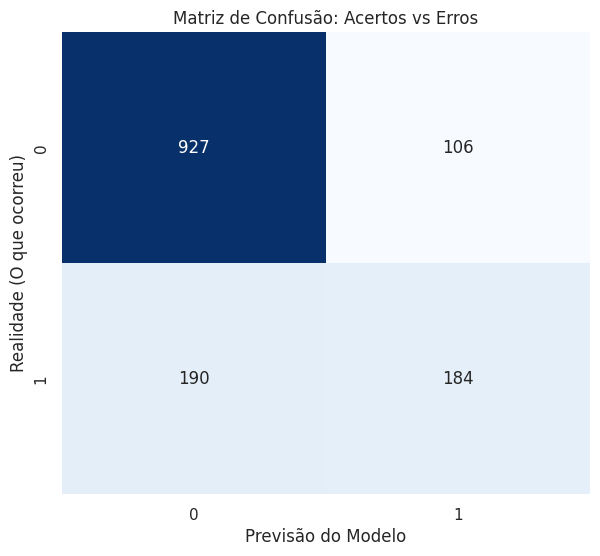

In [10]:
# MATRIZ DE CONFUSÃO
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, previsoes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão do Modelo')
plt.ylabel('Realidade (O que ocorreu)')
plt.title('Matriz de Confusão: Acertos vs Erros')
# Nota: Quadrante inferior direito mostra os clientes que iam sair e o modelo detectou com sucesso.

/tmp/ipython-input-2486690855.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='magma')


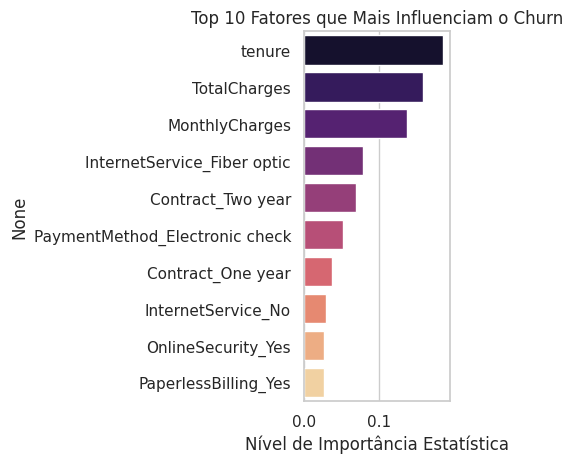

In [11]:
# IMPORTÂNCIA DAS VARIÁVEIS (Direcionamento de Negócio)
plt.subplot(1, 2, 2)
# Calculando a importância das colunas
importancias = pd.Series(modelo_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_10_features = importancias.head(10)

sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='magma')
plt.title('Top 10 Fatores que Mais Influenciam o Churn')
plt.xlabel('Nível de Importância Estatística')

plt.tight_layout()
plt.show()